In [2]:
import math
from itertools import repeat
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy import matrix
from numpy import linalg

In [3]:
def linearFunction(m1, m2, x1, x2, noise):
  r = m1*x1 + m2*x2 + noise
  # print("{0}*{1} + {2}*{3} + {4} = {5}".format(m1, x1, m2, x2, noise, r))
  return r

In [4]:
def getFunction(num_samples, m1, m2, noise):
  x = np.arange(0, num_samples, dtype=float)
  x[0] = linearFunction(m1, m2, 0, 0, noise[0])
  # print(x[0])
  x[1] = linearFunction(m1, m2, x[0], 0, noise[1])
  # print(x[1])
  for i in range(num_samples):
    if (i > 1):
       x[i] = linearFunction(m1, m2, x[i - 1], x[i - 2], noise[i])
      #  print("I#{0}: {1}".format(i, x[i]))
  return x

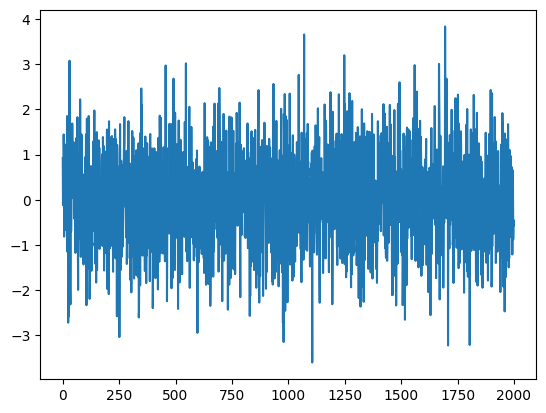

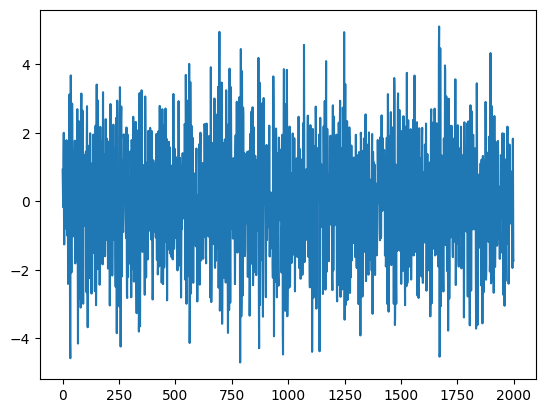

In [5]:
mean = 0
std = 1
num_samples = 2000
noise = np.random.normal(mean, std, size=num_samples)
# print(noise)
plt.plot(noise)
plt.show()

m1 = 0.6530
m2 = -0.7001
x = getFunction(num_samples, m1, m2, noise)
plt.plot(x)
plt.show()

In [6]:
def crossCorrelation(xObservations, filterWeights=[], samples = 8):
  return [singleCrossCorrelation(xObservations, k, samples) for k in filterWeights]

def singleCrossCorrelation(xObservations, k, samples = 8):
  resultToSum = [multiple(xObservations, i, k) for i in range(samples)]
  return sum(resultToSum)/samples

def multiple(xObservations, n, k):
  return xObservations[n + k]*xObservations[n]

def autoCorrelationMatrix(xObservations, filterWeights = [], samples = 8):
  size = len(filterWeights)
  ac = np.zeros([2, 2], dtype=float)
  # print(range(size))
  for row in range(size):
    for col in range(size):
      k = -row + col
      # print("I[{0}, {1}]: -{0} + {1} = {2}".format(row, col, k))
      sc = singleCrossCorrelation(xObservations, k, samples)
      # print(sc)
      ac[row][col] = sc
  return ac

def optimalWeightVector(xObservations, numWeinerScalars = [], samples = 8):
  ac = autoCorrelationMatrix(xObservations, numWeinerScalars, samples - len(numWeinerScalars))
  # print("Autocorrellation matrix: " + str(ac))

  aci = np.linalg.inv(ac)
  # print("Autocorrellation matrix inversed: " + str(aci))

  ccm = crossCorrelation(xObservations, numWeinerScalars, samples - len(numWeinerScalars))
  # print("Wiener coefficients T: " + str(ccm))

  # ccmMatrix = np.array(ccm).reshape(1, len(ccm))
  # print("Wiener coefficients: " + str(ccmMatrix))

  ccmMatrix = np.array(ccm).reshape(len(ccm), 1)
  # # print("Wiener coefficients: " + str(ccmMatrix))
  return [multiplyMatrix(aci, ccmMatrix)]

In [7]:
def multiplyMatrix(A, B):
  rowsA = len(A)
  colsA = len(A[0])
  # print("A[{0}, {1}]".format(str(rowsA), str(colsA)))

  rowsB = len(B)
  colsB = len(B[0])
  # print("B[{0}, {1}]".format(str(rowsB), str(colsB)))

  if  colsA != rowsB:
    return "Lenght mismatch A[{0}, {1}] vs B[{2}, {3}]. Cannot multiply A and B.".format(str(rowsA), str(colsA), str(rowsB), str(colsB))

  C = np.zeros((rowsA, colsB), dtype = float)
  for row in range(rowsA):
    for col in range(colsA):
      for elt in range(colsB):
        C[row, elt] += A[row, col] * B[col, elt]

  return C


# Ejercicio 1: Filtro de Wiener



Wiener Filter Coefficients: [array([[ 0.66660248],
       [-0.72205418]])]


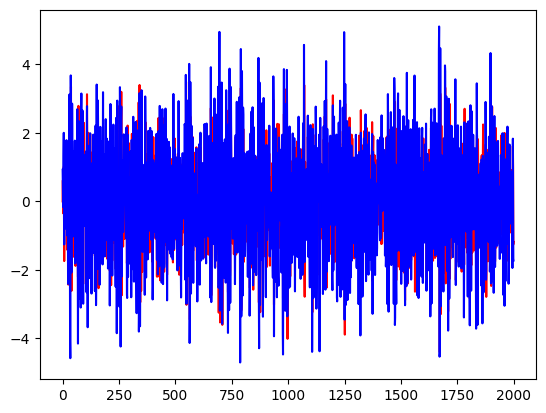

In [8]:
# Ejercicio 1
x = getFunction(num_samples, m1, m2, noise)

result = optimalWeightVector(x, numWeinerScalars=[-1, -2], samples=2000)
print("Wiener Filter Coefficients: {0}".format(result))

rowsB = len(result)
colsB = len(result[0])
# print("result[{0}, {1}]".format(str(rowsB), str(colsB)))

y = [] * 2000
y.insert(0, linearFunction(result[0][0], result[0][1], 0, 0, 0))
y.insert(1, linearFunction(result[0][0], result[0][1], x[0], 0, 0))
for n in range(2000):
  if (n > 1):
    actual = linearFunction(result[0][0], result[0][1], x[n - 1], x[n - 2], 0)
    # print(actual)
    y.insert(n, actual)

# plt.plot(y, x)
# Plot the functions separately
plt.plot(y, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

# Ejercicio dos: Filtro Adaptable

In [14]:
def prediceted_w_coefficients(n, w, mu, noise):
  xn = generateObservations(n, noise, w)
  return w + 2*mu*xn*error(n, w, noise)

def error(n, w, noise):
  return generateObservations(n, noise, w) - sum(w[k]*generateObservations(n - k, noise, w) for k in range(len(w)))

def adaptiveWeinerFilter(wa, mu, noise):
  for n in range(1, len(wa)):
    wa[n, :] = prediceted_w_coefficients(n, wa[n - 1, :], mu, noise)
    # print(wa[n, :])
  return wa

def predictedSignal(x, wa, mu, noise, w1, w2):
  wa = adaptiveWeinerFilter(wa, mu, noise, w1, w2)
  yn = np.zeros(num_samples)
  W1 = wa[num_samples - 1, 0]
  W2 = wa[num_samples - 1, 1]
  yn[0] = linearFunction(W1, W2, 0, 0, 0)
  yn[1] = linearFunction(W1, W2, x[0], 0, 0)
  for n in range(2, len(wa)):
      yn[n] = linearFunction(W1, W2, x[n - 1], x[n - 2], 0)
  return yn

In [62]:
def linearFunction(m, x, noise):
  return sum(m[k]*x[k] for k in range(len(m))) + noise

def generateObservations(n, noise, m):
  if n == 0: return noise[0]

  x = np.zeros(n + 1)
  x[0] = noise[0]
  # x[1] = linearFunction(m, [x[0], 0], noise[1])
  # if n == 1: return x[1]

  for i in range(1, n):
    x[i] = linearFunction(m, [x[i - 1], x[i - 2]], noise[i])
    print("x[{0}] = {1}*{2} + {3}*{4} + {5} = {6}".format(i, m[0], x[i - 1], m[1], x[i - 2], noise[i], x[i]))

  x[n] = linearFunction(m, [x[n - 1], x[n - 2]], noise[n])
  print("x[{0}] = {1}*{2} + {3}*{4} + {5} = {6}".format(n, m[0], x[n - 1], m[1], x[n - 2], noise[n], x[n]))
  return x[n]

In [63]:
# print("noise = {0} | M = {1}".format(noise[:10], [m1, m2]))
# print("----------------------")
# x = generateObservations(0, noise, [m1, m2])
# print("x[{0}] = {1}".format(0, x))
# print("----------------------")
# x = generateObservations(1, noise, [m1, m2])
# print("x[{0}] = {1}".format(1, x))
# print("----------------------")
# x = generateObservations(2, noise, [m1, m2])
# print("x[{0}] = {1}".format(2, x))
# print("----------------------")
# x = generateObservations(3, noise, [m1, m2])
# print("x[{0}] = {1}".format(3, x))
# print("----------------------")
# x = generateObservations(4, noise, [m1, m2])
# print("x[{0}] = {1}".format(4, x))
# print("----------------------")
# x = generateObservations(5, noise, [m1, m2])
# print("x[{0}] = {1}".format(5, x))
# print("----------------------")
# x = generateObservations(6, noise, [m1, m2])
# print("x[{0}] = {1}".format(6, x))

noise = [ 0.92316999 -0.12093742  0.3309673   0.16784479  1.44502968  1.01177885
 -0.81715143  0.43593989  0.46274786 -0.67717387] | M = [0.653, -0.7001]
----------------------
x[0] = 0.9231699917497674
----------------------
x[1] = 0.653*0.9231699917497674 + -0.7001*0.48189258456999773 + -0.12093742004260045 = 0.48189258456999773
x[1] = 0.48189258456999773
----------------------
x[1] = 0.653*0.9231699917497674 + -0.7001*0.0 + -0.12093742004260045 = 0.48189258456999773
x[2] = 0.653*0.48189258456999773 + -0.7001*0.9231699917497674 + 0.33096730286538767 = -0.0006681506344158872
x[2] = -0.0006681506344158872
----------------------
x[1] = 0.653*0.9231699917497674 + -0.7001*0.0 + -0.12093742004260045 = 0.48189258456999773
x[2] = 0.653*0.48189258456999773 + -0.7001*0.9231699917497674 + 0.33096730286538767 = -0.0006681506344158872
x[3] = 0.653*-0.0006681506344158872 + -0.7001*0.48189258456999773 + 0.16784479416892897 = -0.16996450665279997
x[3] = -0.16996450665279997
----------------------
x[

In [ ]:
mu = 0.5
initial_wa = 0.6
number_of_coefficients = 2
num_samples = 2000
wa = np.zeros(shape = (num_samples, number_of_coefficients))
wa[0, :] = np.array([0.1, 0.2])
wa = adaptiveWeinerFilter(wa, mu, noise)

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

print(wa[num_samples - 1, :])
plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
plt.plot(wa[:, 0])

In [ ]:
plt.plot(wa[:, 1])

In [ ]:
mu = 0.4
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
mu = 0.3
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
mu = 0.2
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
mu = 0.1
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
mu = 0.09
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
mu = 0.05
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()

In [ ]:
mu = 0.04
wa = np.zeros(wa_len)
wa[0] = initial_wa

yn = predictedSignal(x, wa, mu, noise, result[0][0], result[0][1])

plt.plot(yn, 'r', label='Wiener Predictor')
plt.plot(x, 'b', label='Data')
plt.show()